In [98]:
import pandas as pd
import json
import gzip
# sudo pip install pandas


In [99]:
def json_gz_to_dataframe(gz_file_path):
    data = []
    
    # Open and read the gzipped JSON file
    with gzip.open(gz_file_path, 'rt') as file:
        # Read the file line-by-line
        for line in file:
            try:
                json_data = json.loads(line)  # Load each line as a separate JSON object
                
                # Loop through the transcripts in the JSON data
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            # Create the 5-mers for the position -1, 0, and 1 from the 7-mer (sequence)
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            # For each read in the list of reads, create a row
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    # Define the columns, including the new 5-mer and ori_nucleotide columns
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'position_0', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=columns)
    
    return df

# Example usage
# df = json_gz_to_dataframe('dataset0.json.gz')  # Replace with actual path
# print(df.head())

In [100]:
df = json_gz_to_dataframe('data/dataset0.json.gz')  # Replace with actual path
print(df.head())

df.to_csv('data/dataset0.csv', index=False) # save file as csv


In [6]:
print(df.shape)

(11027106, 13)


In [7]:
# Step 1: Read in the 'data.info.labelled' file
# Adjust 'sep' based on the format (e.g., ',' for CSV or '\t' for tab-separated files)
data_info = pd.read_csv('data/data.info.labelled', sep=',')

df = pd.read_csv('data/dataset0.csv')

data_info.rename(columns={'transcript_position': 'position_0'}, inplace=True)

# Step 2: Perform the merge using 'transcript_id'
merged_df = pd.merge(df, data_info, on=['transcript_id', 'position_0'], how='inner')

merged_df.to_csv('data/merged_df.csv', index=False)
# Step 3: Display the merged DataFrame
print(merged_df.head())

# studies/ProjectStorage/data/merged_df.csv


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243              0.00299      2.06       125.0   
1  ENST00000000233             243              0.00631      2.53       125.0   
2  ENST00000000233             243              0.00465      3.92       109.0   
3  ENST00000000233             243              0.00398      2.06       125.0   
4  ENST00000000233             243              0.00664      2.92       120.0   

   position_0  dwelling_time_0   sd_0  mean_0  position_1  dwelling_time_1  \
0         244          0.01770  10.40   122.0         245          0.00930   
1         244          0.00844   4.67   126.0         245          0.01030   
2         244          0.01360  12.00   124.0         245          0.00498   
3         244          0.00830   5.01   130.0         245          0.00498   
4         244          0.00266   3.94   129.0         245          0.01300   

    sd_1  mean_1          gene_id  label  
0

In [8]:
# jupyter notebook --no-browser --ip=0.0.0.0 --port=8888


Normalise data

In [90]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# List of columns to scale
scaled_columns = [
    'dwelling_time_neg_1', 
    'sd_neg_1', 
    'mean_neg_1', 
    'dwelling_time_0', 
    'sd_0', 
    'mean_0', 
    'dwelling_time_1', 
    'sd_1', 
    'mean_1'
]

# merged_df = pd.read_csv("studies/ProjectStorage/data/merged_df.csv")
merged_df = pd.read_csv("data/merged_df.csv")
# Scale the selected columns
merged_df[scaled_columns] = scaler.fit_transform(merged_df[scaled_columns])

# Check the modified DataFrame
print(merged_df.head())


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243            -0.945395 -0.887354    1.182045   
1  ENST00000000233             243            -0.331941 -0.705037    1.182045   
2  ENST00000000233             243            -0.638668 -0.165843   -0.159518   
3  ENST00000000233             243            -0.762467 -0.887354    1.182045   
4  ENST00000000233             243            -0.270965 -0.553752    0.762807   

   position_0  dwelling_time_0      sd_0    mean_0  position_1  \
0         244         1.801522  1.734026  0.838074         245   
1         244         0.054822 -0.170495  1.145105         245   
2         244         1.028145  2.265830  0.991589         245   
3         244         0.028414 -0.057487  1.452136         245   
4         244        -1.035450 -0.413131  1.375378         245   

   dwelling_time_1      sd_1    mean_1          gene_id  label  
0         0.506790  4.659152 -0.387623  ENSG0000000

In [93]:
# lag
lag_columns = [
    'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
    'dwelling_time_0', 'sd_0', 'mean_0',
    'dwelling_time_1', 'sd_1', 'mean_1'
]
for lag in range(1, 4):
    for col in lag_columns:
        merged_df[f'lag_{lag}_{col}'] = merged_df.groupby(['transcript_id', 'position_0'])[col].shift(lag)
merged_df.fillna(0, inplace=True)  # Replace NaNs with 0

In [95]:
# rolling mean
def compute_rolling_statistics(group, window=3):
    for col in [
        'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'dwelling_time_0', 'sd_0', 'mean_0',
        'dwelling_time_1', 'sd_1', 'mean_1'
    ]:
        group[f'rolling_mean_{col}'] = group[col].rolling(window=window, min_periods=1).mean()
        group[f'rolling_sd_{col}'] = group[col].rolling(window=window, min_periods=1).std()  # Standard deviation
        group[f'dwelling_time_{col}'] = group[col].rolling(window=window, min_periods=1).mean()
    return group



merged_df = merged_df.groupby(['transcript_id', 'position_0']).apply(compute_rolling_statistics)


KeyboardInterrupt: 

In [ ]:
merged_df.shape

In [27]:
### EDA###

import matplotlib.pyplot as plt
import seaborn as sns

# Example: Scatter plot of current mean vs lagged mean
def plot(merged_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df['mean_0'], y=merged_df['lag_1_mean_0'])
    plt.title('Current Mean vs Lagged Mean')
    plt.xlabel('Mean at Position 0')
    plt.ylabel('Lagged Mean at Position 0')
    plt.show()


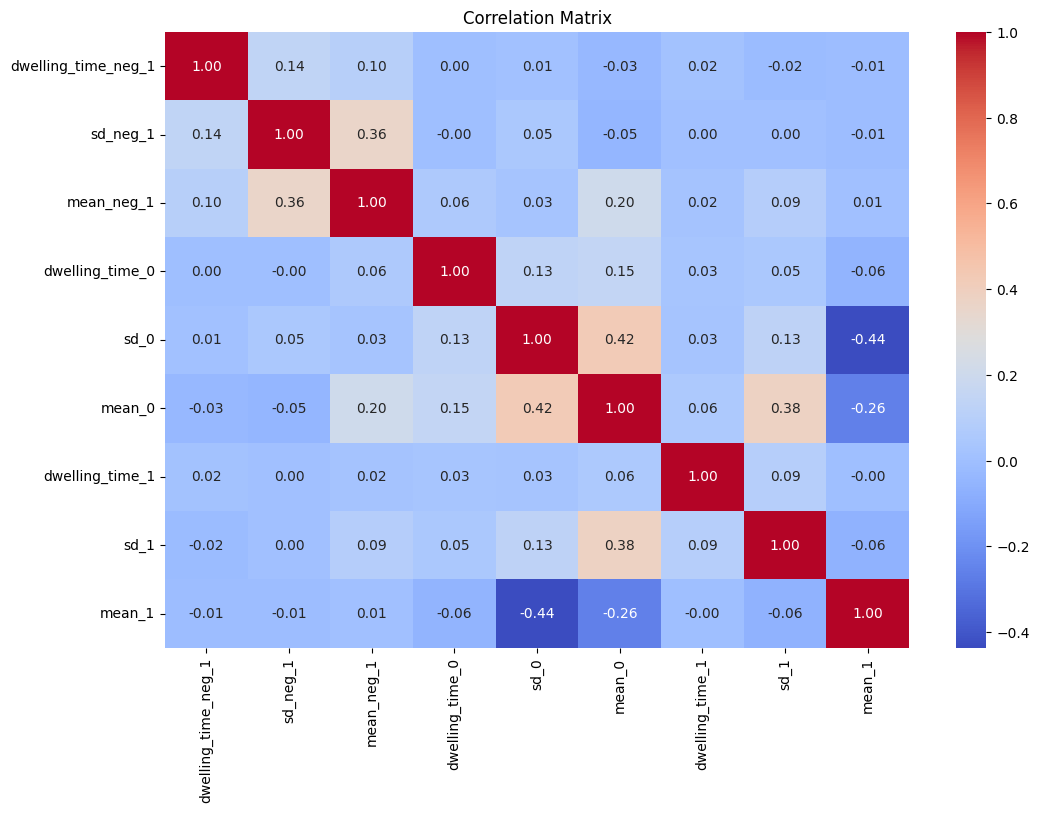

In [28]:
relevant_columns = [
    'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
    'dwelling_time_0', 'sd_0', 'mean_0',
    'dwelling_time_1', 'sd_1', 'mean_1'
]

for col in relevant_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Calculate the correlation matrix for relevant columns
correlation_matrix = merged_df[relevant_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# merged_df.to_csv("merged_norm_lag.csv",  index=False)

: 

Feature select

In [19]:
import pandas as pd
merged_df = pd.read_csv("merged_norm_lag.csv")
merged_df = merged_df.drop(columns=['Unnamed: 0'])


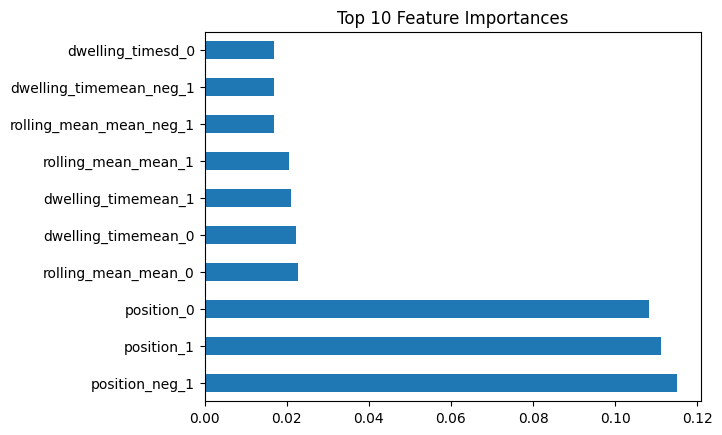

In [29]:
X = merged_df.drop(columns=['transcript_id', 'gene_id', 'label'])
y = merged_df['label']



from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt
feature_importances = pd.Series(importances, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()


In [31]:
from sklearn.feature_selection import SelectKBest, f_regression
# Select top 10 features based on univariate statistics

merged_df.fillna(0, inplace=True) 
X = merged_df.drop(columns=['transcript_id', 'gene_id', 'label'])

selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)
selected_features = selector.get_support(indices=True)

# Assuming merged_df is your original DataFrame and X is defined as above
selected_feature_names = X.columns[selected_features]

# Convert to a list if needed
selected_feature_names_list = selected_feature_names.tolist()

# Display the selected feature names
print(selected_feature_names_list)


['mean_neg_1', 'mean_0', 'lag_1_mean_neg_1', 'lag_1_mean_0', 'lag_2_mean_0', 'lag_3_mean_0', 'rolling_mean_mean_neg_1', 'dwelling_timemean_neg_1', 'rolling_mean_mean_0', 'dwelling_timemean_0']


In [24]:
merged_df.columns

Index(['transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1',
       'mean_neg_1', 'position_0', 'dwelling_time_0', 'sd_0', 'mean_0',
       'position_1', 'dwelling_time_1', 'sd_1', 'mean_1', 'gene_id', 'label',
       'lag_1_dwelling_time_neg_1', 'lag_1_sd_neg_1', 'lag_1_mean_neg_1',
       'lag_1_dwelling_time_0', 'lag_1_sd_0', 'lag_1_mean_0',
       'lag_1_dwelling_time_1', 'lag_1_sd_1', 'lag_1_mean_1',
       'lag_2_dwelling_time_neg_1', 'lag_2_sd_neg_1', 'lag_2_mean_neg_1',
       'lag_2_dwelling_time_0', 'lag_2_sd_0', 'lag_2_mean_0',
       'lag_2_dwelling_time_1', 'lag_2_sd_1', 'lag_2_mean_1',
       'lag_3_dwelling_time_neg_1', 'lag_3_sd_neg_1', 'lag_3_mean_neg_1',
       'lag_3_dwelling_time_0', 'lag_3_sd_0', 'lag_3_mean_0',
       'lag_3_dwelling_time_1', 'lag_3_sd_1', 'lag_3_mean_1'],
      dtype='object')

Train test split

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = df_dropped
df['group'] = df['transcript_id'] + '_' + df['position_0'].astype(str)

X = merged_df.drop(columns=['transcript_id', 'gene_id', 'label'])
y = merged_df['label']


# Step 2: Get unique groups and split them
unique_groups = df['group'].unique()
train_groups, test_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# Step 3: Create train and test sets based on the groups
train_set = df[df['group'].isin(train_groups)]
test_set = df[df['group'].isin(test_groups)]

# Prepare features and target variable
X_train = train_set.drop(columns=['label', 'group', 'transcript_id', 'position_0'])
y_train = train_set['label']
X_test = test_set.drop(columns=['label', 'group', 'transcript_id', 'position_0'])
y_test = test_set['label']

X_train = pd.get_dummies(X_train, columns=['gene_id'], drop_first=True) # one hot encode the geneid
X_test = pd.get_dummies(X_test, columns=['gene_id'], drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Step 4: Apply over-sampling (or under-sampling) to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print("Original training class distribution:")
print(y_train.value_counts())
print("\nResampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original training class distribution:
label
0    265968
1      9297
Name: count, dtype: int64

Resampled training class distribution:
label
0    265968
1    265968
Name: count, dtype: int64


In [61]:
df = pd.read_csv("data/merged_df.csv")

In [64]:
# df['group'] = df['transcript_id'] + '_' + df['position_0'].astype(str)
df['group'].unique()

array(['ENST00000000233_244', 'ENST00000000233_261',
       'ENST00000000233_316', ..., 'ENST00000641834_1531',
       'ENST00000641834_1537', 'ENST00000641834_1693'], dtype=object)

In [67]:
lab = df['transcript_id'] + '_' + df['position_0'].astype(str) + '_' + df['label'].astype(str)

In [75]:
group = df['transcript_id'] + '_' + df['position_0'].astype(str)

In [80]:


# Function to check if there are rows with both labels 0 and 1 in each group
def check_labels_in_group(df):
    result = df.groupby('group')['label'].apply(lambda x: {0, 1}.issubset(set(x)))
    return result[result == True]

# Applying the function
result = check_labels_in_group(df)
print(result)



Series([], Name: label, dtype: bool)


In [82]:
pd.read_csv("data/dataset0.csv").shape

(11027106, 13)

In [84]:
df.shape

(11027106, 16)